### Datetime values at regular intervals

In [1]:
from datetime import datetime, timedelta

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

START = datetime(2022, 11, 17)
END = datetime(2022, 12, 1)
delta = timedelta(minutes=5)

def get_date_times(start=START, end=END, delta=delta, sep='-'):
    return [dt.strftime(f'%Y{sep}%m{sep}%d{sep}%H{sep}%M') for dt in datetime_range(start, end, delta)]

### Data importation

In [2]:
import glob
import json
from json import JSONDecodeError
import pandas as pd
import numpy as np

In [3]:
def get_data(name='velib', start=START, end=END, delta=delta):
    # Params customization depending on the data to be imported
    if name.lower() == 'velib':
        sep = '-'
        path_prefix = 'data/velib/citybike_paris_'
        path_suffix = '-*.json'
    elif name.lower() == 'weather':
        sep = '_'
        path_prefix = 'data/weather/'
        path_suffix = '*_Paris.json'
    else:
        print('Invalid data name!')
        return
    
    # Needed datetime values
    date_times = get_date_times(start, end, delta, sep)
    
    # Empty DataFrame
    data = pd.DataFrame()

    # For every datetime in the datetime list
    for date_time in date_times:
        # File opening
        path = glob.glob(path_prefix + date_time + path_suffix)[0]
        with open(path) as json_file:        
            # JSON data into Python dictionnary
            try:
                to_add = json.load(json_file)
            except JSONDecodeError:
                print(f'JSONDecodeError while reading {path}')
                continue

            # If importing 'velib', extracting the stations' data
            if name.lower() == 'velib':
                to_add = to_add['network']['stations']

            # Dictionary to DataFrame
            to_add = pd.json_normalize(to_add)
            
            # Current datetime column
            to_add['datetime'] = pd.to_datetime(f'{date_time[:4]}-{date_time[5:7]}-{date_time[8:10]} {date_time[11:13]}:{date_time[14:16]}:00')

            # Append to the DataFrame
            data = pd.concat([data, to_add])

    return data

In [4]:
def get_all_data(start=START, end=END, delta=delta):
    # Velib
    velib = get_data('velib', start, end, delta)
    velib = velib[['datetime', 'empty_slots', 'free_bikes']]

    ## Filling rate
    velib['filling_rate'] = velib.free_bikes / (velib.free_bikes + velib.empty_slots)

    ## Weekends' filling rates
    velib['week_end_filling_rate'] = np.ma.masked_where(~velib.datetime.dt.weekday.isin([5, 6]), velib.filling_rate)

    # Weather
    weather = get_data('weather', start, end, delta)
    weather = weather[['datetime', 'main.temp', 'main.temp_min', 'main.temp_max']]

    ## Temp to celcius
    weather['main.temp'] -= 273.15
    weather['main.temp_min'] -= 273.15
    weather['main.temp_max'] -= 273.15
    
    # Merge the two datasets
    data = pd.merge(velib, weather, on= 'datetime')
    
    # Mean by datetime
    data = data.groupby('datetime').mean().reset_index()
    
    return data

### Plotting

In [5]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

#### 1. Over the course of one day (24h), what can be said about the evolution of the filling of stations, for the whole network?

In [6]:
%%time
# Two-hours data on two weeks
start = START ; end = start + timedelta(days=14) ; delta = timedelta(minutes=120)
data = get_all_data(start=START, end=end, delta=delta)

JSONDecodeError while reading data/velib\citybike_paris_2022-11-29-02-00-01.json
JSONDecodeError while reading data/velib\citybike_paris_2022-11-29-04-00-01.json
JSONDecodeError while reading data/velib\citybike_paris_2022-11-29-06-00-02.json
CPU times: total: 7.09 s
Wall time: 19.7 s


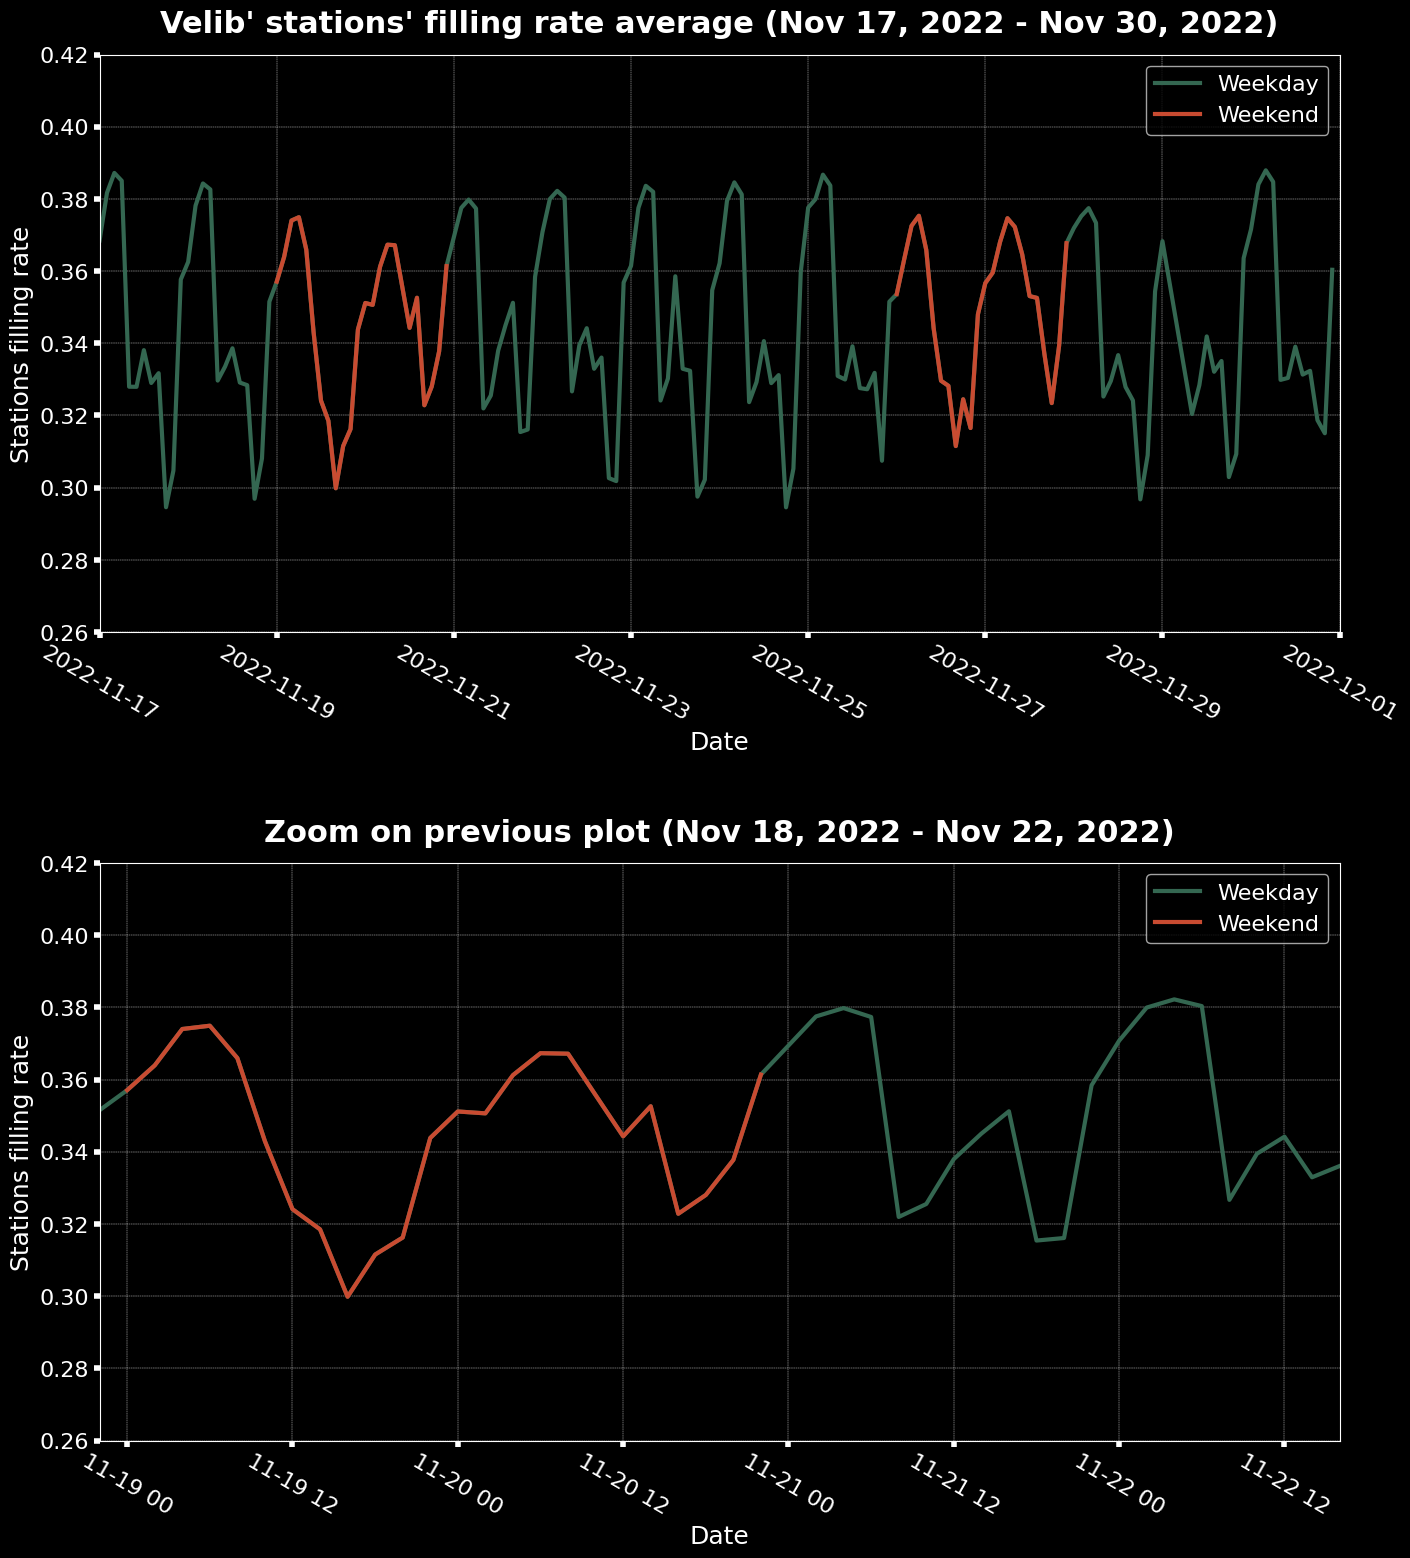

In [7]:
# Plot
## Initialization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 18))
fig.subplots_adjust(hspace=.4)



## First plot (filling rate)

### Plots
ax1.plot('datetime', 'filling_rate', data=data, label='Weekday', linewidth=3, color='#346751')
ax1.plot('datetime', 'week_end_filling_rate', data=data, label='Weekend', linewidth=3, color='#C84B31')

### Axes & grid
ax1.set_xlim([start, end])
ax1.set_ylim([.26, .42])

ax1.set_xlabel('Date', fontsize=18)
ax1.set_ylabel('Stations filling rate', fontsize=18)

ax1.tick_params(grid_linestyle='--', grid_linewidth=.3, labelsize=16, width=4, length=4)
ax1.tick_params('x', labelrotation=330)

ax1.grid()

### Legend & title
ax1.legend(fontsize=16)

f_start = datetime.strftime(data.datetime.iloc[0], '%b %d, %Y')
f_end = datetime.strftime(data.datetime.iloc[-1], '%b %d, %Y')
ax1.set_title(f'Velib\' stations\' filling rate average ({f_start} - {f_end})',
              fontsize=22, fontweight=600, pad=16)



## Second plot (zoom of the first)

### Data
n = len(data) // 7
zoom_data = data.iloc[n:3*n] # a subset of the data (2/7)
zoom_start = zoom_data.iloc[0].datetime
zoom_end = zoom_data.iloc[-1].datetime

### Plots
ax2.plot('datetime', 'filling_rate', data=zoom_data, label='Weekday', linewidth=3, color='#346751')
ax2.plot('datetime', 'week_end_filling_rate', data=zoom_data, label='Weekend', linewidth=3, color='#C84B31')

### Axes & grid 
ax2.set_xlim([zoom_start, zoom_end])
ax2.set_ylim([.26, .42])

ax2.set_xlabel('Date', fontsize=18)
ax2.set_ylabel('Stations filling rate', fontsize=18)

ax2.tick_params(grid_linestyle='--', grid_linewidth=.3, labelsize=16, width=4, length=4)
ax2.tick_params('x', labelrotation=330)

ax2.grid()

### Legend & title
ax2.legend(fontsize=16)

f_zoom_start = datetime.strftime(zoom_start, '%b %d, %Y')
f_zoom_end = datetime.strftime(zoom_end, '%b %d, %Y')
ax2.set_title(f'Zoom on previous plot ({f_zoom_start} - {f_zoom_end})',
              fontsize=22, fontweight=600, pad=16)



## Show
plt.show()

During a week, there are two observable trends: one on weekdays and the other one during the weekend.

For each weekday, we have 4 great variations: the stations drastically go empty from 6 to 9 AM, then the filling rates goes up untill 12 PM from where we can observe a second decrease - a slight one this time - until 6 PM, and finally the bikes are getting back to the stations.

The weekend's behaviour is different since there are only 2 daily variations: a slight decrease of the filling rate from 6 AM to 6 PM, then the return of the bikes to the different stations.

#### 2. What is the impact of weather on the use of Vélib' bikes? 

In [8]:
%%time
# Hourly data on one week
start = START ; end = start + timedelta(days=7) ; delta = timedelta(minutes=60)
data = get_all_data(start=START, end=end, delta=delta)

CPU times: total: 9.03 s
Wall time: 21.4 s


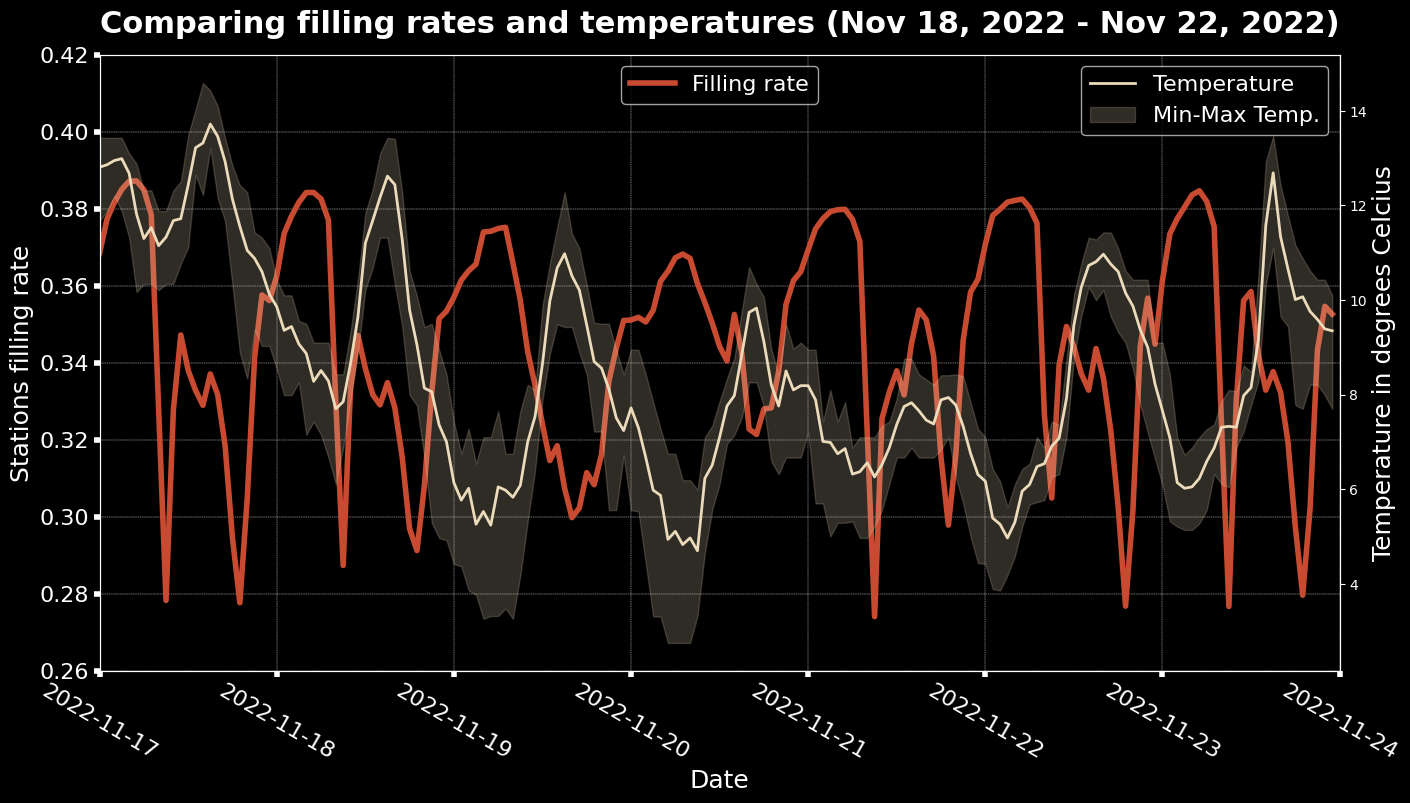

In [9]:
# Plot
## Initialization
fig, ax1 = plt.subplots(figsize=(16, 8))



## First plot

### Plot (filling rate)
ax1.plot('datetime', 'filling_rate', data=data, label='Filling rate', linewidth=4, color='#C84B31')

### Axes & grid
ax1.set_xlim([start, end])
ax1.set_ylim([.26, .42])

ax1.set_xlabel('Date', fontsize=18)
ax1.set_ylabel('Stations filling rate', fontsize=18)

ax1.tick_params(grid_linestyle='--', grid_linewidth=.3, labelsize=16, width=4, length=4)
ax1.tick_params('x', labelrotation=330)

ax1.grid()

### Legend
ax1.legend(fontsize=16, loc='upper center')



## Second plot (temperature variations)

### Plots
ax2 = ax1.twinx()
ax2.plot('datetime', 'main.temp', data=data, label='Temperature', linewidth=2, color='#ECDBBA')
ax2.fill_between(x='datetime', y1='main.temp_min', y2='main.temp_max', data=data,
                 label='Min-Max Temp.', alpha=.2, color='#ECDBBA')

### Ax label
ax2.set_ylabel('Temperature in degrees Celcius', fontsize=18)

### Legend
ax2.legend(fontsize=16)

### Title
f_start = datetime.strftime(zoom_start, '%b %d, %Y')
f_end = datetime.strftime(zoom_end, '%b %d, %Y')
plt.title(f'Comparing filling rates and temperatures ({f_zoom_start} - {f_zoom_end})',
              fontsize=22, fontweight=600, pad=16)



### Show
plt.show()

The temperature doesn't seem to have a particular effect on the Velib' bikes use. The lattest may just accomodate with people's daily habits: going to school/work every morning during the week, sometimes moving at the break time, getting back home in the evening and having some fun during the weekend.